# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [71]:
PATH_TO_DATA = "/home/bananna/Downloads/bi-ml-competition-2023"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [14]:
df_train_features.shape

(31698, 245)

In [86]:
df_train_features.head(10)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.000000,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.250000,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.500000,0,0,3,0
df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,3,...,8.064697,0,0,1,0,0.428571,0,0,1,0
7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,4,...,2.899237,0,0,11,0,0.636364,0,0,0,0
0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,1,...,34.424866,0,0,19,0,0.371429,0,0,0,0
892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,1,...,0.000012,0,0,3,0,0.250000,0,0,1,0


In [92]:
df_train_features.columns.tolist() #хочу почитать подробнее

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

То есть, в датафрейме фичи каждого игрока, закодированные r\[номер\] и d\[номер\]

In [88]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

## <left>Наша первая модель

In [57]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [7]:
%%time
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 1min 27s, sys: 166 ms, total: 1min 27s
Wall time: 7.83 s


RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [8]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [9]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7855852911989095


Посмотрим на accuracy:

In [10]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.7


## <left>Посылка

In [65]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

ValueError: X has 245 features, but RandomForestClassifier is expecting 179 features as input.

In [ ]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [32]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [128]:
%%time
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=20, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 29.6 s, sys: 2.3 s, total: 31.9 s
Wall time: 2min 26s


In [129]:
cv_scores_rf

array([0.79015385, 0.79124826, 0.78293717, 0.788038  , 0.7898648 ])

In [130]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7884484147612155


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [156]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [157]:
print(match.keys())

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])


In [158]:
for i in match.keys():
    print(f"{i} length =", len(i))

game_time length = 9
match_id_hash length = 13
teamfights length = 10
objectives length = 10
chat length = 4
game_mode length = 9
lobby_type length = 10
players length = 7
targets length = 7


In [159]:
print('length of all the chat:', len(match["chat"][0].get("text"))) #weird(?)

length of all the chat: 36


In [160]:
for i in match.keys():
    print(match[i])
    print()

2049

75112757bde649d5cff1c7cd4f1275c6

[{'start': 306.755, 'end': 338.551, 'last_death': 323.454, 'deaths': 3, 'players': [{'deaths_pos': {}, 'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1}, 'item_uses': {}, 'killed': {'npc_dota_hero_faceless_void': 114}, 'deaths': 0, 'buybacks': 0, 'damage': 383, 'healing': 0, 'gold_delta': 336, 'xp_delta': 440}, {'deaths_pos': {}, 'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1}, 'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1}, 'killed': {}, 'deaths': 0, 'buybacks': 0, 'damage': 458, 'healing': 0, 'gold_delta': -10, 'xp_delta': 76}, {'deaths_pos': {}, 'ability_uses': {}, 'item_uses': {}, 'killed': {}, 'deaths': 0, 'buybacks': 0, 'damage': 0, 'healing': 0, 'gold_delta': 174, 'xp_delta': 249}, {'deaths_pos': {}, 'ability_uses': {'zuus_arc_lightning': 4, 'zuus_lightning_bolt': 1, 'zuus_thundergods_wrath': 1}, 'item_uses': {'tpscroll': 1, 'clarity': 1}, 'killed': {}, 'deaths': 0, 'buybacks': 0, 'damage': 1179, 'healing': 0, 'gold_

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

In [33]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

Информация о количестве использованных способностей:

In [34]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

In [38]:
things_in_df_already = ['hero_id',
 'kills',
 'deaths',
 'assists',
 'denies',
 'gold',
 'lh',
 'xp',
 'health',
 'max_health',
 'max_mana',
 'level',
 'x',
 'y',
 'stuns',
 'creeps_stacked',
 'camps_stacked',
 'rune_pickups',
 'firstblood_claimed',
 'teamfight_participation',
 'towers_killed',
 'roshans_killed',
 'obs_placed',
 'sen_placed']

In [46]:
n = 0
for i in player:
    n+=1
print()
print('the amount of all the features for every player:',n)
print('things_in_df_already:', len(things_in_df_already))


the amount of all the features for every player: 69
things_in_df_already: 24


In [172]:
n = 0
for i in player:
    if i not in things_in_df_already:
        print(i, end = ', ')
        n+=1
print()
print()
print('the amount:', n)

player_slot, hero_name, account_id_hash, ability_upgrades, observers_placed, max_hero_hit, times, gold_t, lh_t, dn_t, xp_t, obs_log, sen_log, obs_left_log, sen_left_log, purchase_log, kills_log, buyback_log, runes_log, obs, sen, actions, pings, purchase, gold_reasons, xp_reasons, killed, item_uses, ability_uses, hero_hits, damage, damage_taken, damage_inflictor, runes, killed_by, kill_streaks, multi_kills, life_state, healing, damage_inflictor_received, randomed, pred_vict, hero_inventory, hero_stash, nearby_creep_death_count, 

the amount: 45


45 фичей мы можем теоритически добавить в модель 

но если подумать, не все они подходят нам. Выделим +\- подходящие

__________________________________

player_slot - с помощью него мы поймем, в какой команде игрок. 0,1,2,3,4 - это radiant 

hero_name 

account_id_hash

**ability_upgrades** - какой-то словарь непонятный

**observers_placed** - просто число, удобно использовать

**max_hero_hit** - нрн использую player\["max_hero_hit"\]\['value'\]

times

gold_t

lh_t

dn_t

xp_t

obs_log

sen_log

obs_left_log

sen_left_log

purchase_log

kills_log

buyback_log

runes_log

obs

sen

**actions** какие-то цифры вообще непонятные

**pings** сэйм

**purchase** sum(player\["purchase"\].values())

gold_reasons

xp_reasons

**killed** не поняла, что значат цифры

**item_uses** sum(player\["item_uses"\].values())

**ability_uses** sum(player\["ability_uses"\].values())

**hero_hits** sum(player\["hero_hits"\].values()) хорошо бы, но что такое null???????

**damage** sum(player\["damage"\].values()) видимо...

**damage_taken** sum(player\["damage_taken"\].values()) хотя зачем собсна, если это сильно кореллирует с дамаг

damage_inflictor

runes

killed_by

**kill_streaks** пустой список почему-то, но можно сделать sum(player\["kill_streaks"\].values())

**multi_kills** пустой список почему-то, но можно сделать sum(player\["multi_kills"\].values())

**life_state** вообще ниче не понятно, {'0': 3826, '1': 26, '2': 246} это че

**healing** тоже можно сумму sum(player\["healing"\].values())

damage_inflictor_received

randomed  %False\True

pred_vict

hero_inventory

hero_stash

**nearby_creep_death_count**  - просто число, удобно использовать

In [100]:
player = match["players"][1]
player["max_hero_hit"]

{'type': 'max_hero_hit',
 'time': 1922.314,
 'max': True,
 'inflictor': 'pudge_meat_hook',
 'unit': 'npc_dota_hero_pudge',
 'key': 'npc_dota_hero_treant',
 'value': 370,
 'slot': 1,
 'player_slot': 1}

In [53]:
print('Возможные слоты:')
for player in match['players']:
    print(player['player_slot'], end=', ')

Возможные слоты:
0, 1, 2, 3, 4, 128, 129, 130, 131, 132, 

От 0 до 4 это игроки из команды Radiant

Нам посоветовали добавить KDA, поэтому добавим конечно же. А потом посмотрим другие признаки

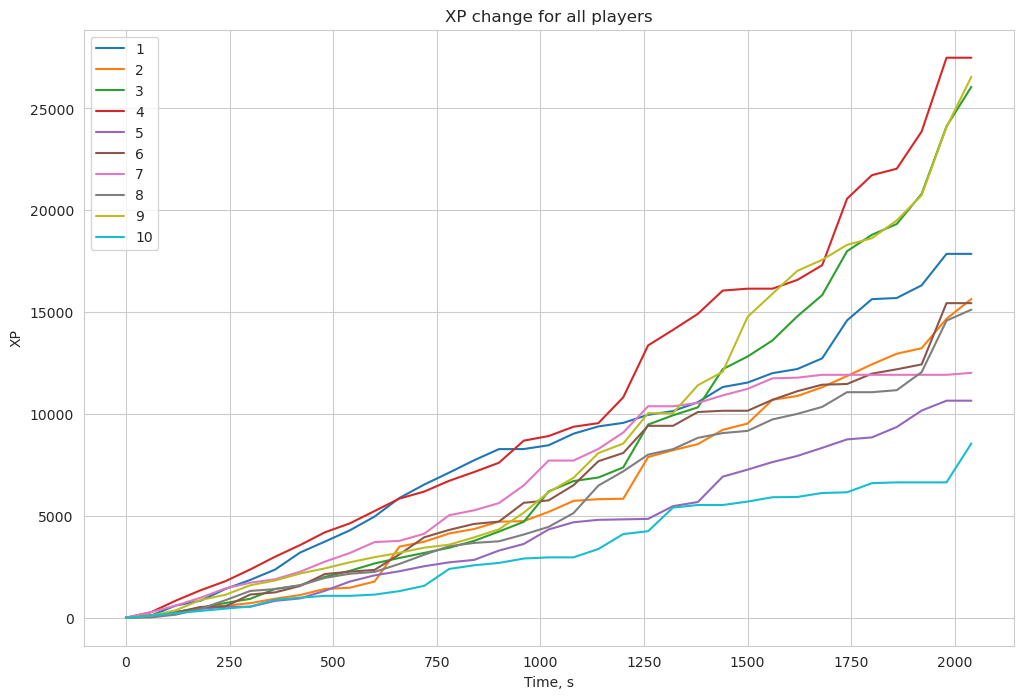

In [56]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [76]:
!pip install ujson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 737.6 kB/s eta 0:00:00MB/s eta 0:00:01


In [77]:
!pip install tqdm

In [17]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [18]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [19]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [20]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [27]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 95.4 ms, sys: 96.7 ms, total: 192 ms

Wall time: 1min 39s


In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513

ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

Попробую добавить KDA в фичи

### objectives

Посмотрим на элементы, оценим их структуру и погуглим, а что это вообще все значит...

In [134]:
for obj in match['objectives']:
    print(obj, end='\n')
    
'''
FIRSTBLOOD
Hero kills. unreliable gold to the killer; 
this is called First Blood!. 
Bonus gold is also awarded for stopping kill streaks.

TOWER_DENY
Denying is the act of preventing enemy heroes from getting the last hit on a friendly unit 
by last hitting the unit oneself.

ROSHAN_KILL
Roshan is the most powerful neutral creep in Dota 2. 

AEGIS
предмет за убийство, который выпадает из Рошана, после первой и всех последующих его смертей. 

BARRACKS_KILL
buildings, defended by their tier 3 towers, 
that are responsible for keeping lane creeps as powerful as their counterparts. 
'''

{'time': 53.154, 'type': 'CHAT_MESSAGE_FIRSTBLOOD', 'slot': 2, 'key': 7, 'player_slot': 2}
{'time': 947.135, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': -1}
{'time': 1069.106, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 0, 'player_slot': 0}
{'time': 1116.761, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 3, 'slot': -1}
{'time': 1153.485, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 3, 'slot': -1}
{'time': 1282.254, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 2, 'player_slot': 2}
{'time': 1510.065, 'type': 'CHAT_MESSAGE_TOWER_DENY', 'team': 60, 'slot': 7, 'player_slot': 130}
{'time': 1544.323, 'type': 'CHAT_MESSAGE_TOWER_DENY', 'team': 60, 'slot': 4, 'player_slot': 4}
{'time': 1719.222, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 2, 'player_slot': 2}
{'time': 1778.892, 'type': 'CHAT_MESSAGE_ROSHAN_KILL', 'team': 2}
{'time': 1779.828, 'type': 'CHAT_MESSAGE_AEGIS', 'slot': 2, 'player_slot': 2}
{'time': 1860.704, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team':

'\nFIRSTBLOOD\nHero kills. unreliable gold to the killer; \nthis is called First Blood!. \nBonus gold is also awarded for stopping kill streaks.\n\nTOWER_DENY\nDenying is the act of preventing enemy heroes from getting the last hit on a friendly unit \nby last hitting the unit oneself.\nROSHAN_KILL\nRoshan is the most powerful neutral creep in Dota 2. \nAEGIS\nпредмет за убийство, который выпадает из Рошана, после первой и всех последующих его смертей. \nBARRACKS_KILL\nbuildings, defended by their tier 3 towers, \nthat are responsible for keeping lane creeps as powerful as their counterparts. \n'

**Посмотрим, что такое ключи у бараков:**

In [137]:
barracks_keys = []
for match in read_matches(os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl")):
    for obj in match["objectives"]:
        if obj["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
            if obj["key"] not in barracks_keys:
                barracks_keys.append(obj["key"])
print('barracks_keys:', barracks_keys)

  0%|          | 0/31698 [00:00<?, ?it/s]

barracks_keys: ['512', '2', '1', '256', '4', '8', '16', '32', '1024', '2048', '64', '128']


In [140]:
sorted(int(i) for i in barracks_keys)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

Тут пришлось гуглить, короче, первые 6 это бараки radiant, остальные - Dire. Но я бы тут не догадался, уж извините

**Кажется, абсолютно все типы objectives довольно важные, и их все включу в анализ**

Что еще есть в записи каждого матча:

In [186]:
for i in match.keys():
    print(i)

game_time
match_id_hash
teamfights
objectives
chat
game_mode
lobby_type
players
targets


game_time - уже есть

match_id_hash - уже есть

**teamfights**

objectives - уже есть

**chat**

game_mode - уже есть

lobby_type - уже есть

players - уже есть

**targets**

In [193]:
for target in match["targets"]:
    print(target)

game_time
duration
time_remaining
radiant_win
next_roshan_team


+ Из него у нас уже есть время, оставшееся время будет коррелировать с ним и с длительностью, но можно добавить.
+ radiant_win это как бы ответ который мы хотим получить
+ next_roshan_team - хз что это. Он спаунится в своей пещере, убить может любая команда... не понимаю

Итого особо использовать тут нечего

In [195]:
len(match["teamfights"])

5

In [196]:
match["teamfights"]

[{'start': 306.755,
  'end': 338.551,
  'last_death': 323.454,
  'deaths': 3,
  'players': [{'deaths_pos': {},
    'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
    'item_uses': {},
    'killed': {'npc_dota_hero_faceless_void': 114},
    'deaths': 0,
    'buybacks': 0,
    'damage': 383,
    'healing': 0,
    'gold_delta': 336,
    'xp_delta': 440},
   {'deaths_pos': {},
    'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
    'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
    'killed': {},
    'deaths': 0,
    'buybacks': 0,
    'damage': 458,
    'healing': 0,
    'gold_delta': -10,
    'xp_delta': 76},
   {'deaths_pos': {},
    'ability_uses': {},
    'item_uses': {},
    'killed': {},
    'deaths': 0,
    'buybacks': 0,
    'damage': 0,
    'healing': 0,
    'gold_delta': 174,
    'xp_delta': 249},
   {'deaths_pos': {},
    'ability_uses': {'zuus_arc_lightning': 4,
     'zuus_lightning_bolt': 1,
     'zuus_thundergods_wrath': 1},
    'item_uses': {'tpsc

Чет сложно в этом разобраться, и многое уже внесено из раздела "игроки", пока не буду трогать

In [201]:
match["chat"]

[{'player_slot': 132,
  'time': 2045.667,
  'text': '* * *...**** **** ***** **** ** ****'}]

Тут этот раздел короткий, но видимо там может быть много сообщений. Можно считывать, от какой команды сообщение, а также учитывать длину текста. Много сообщений могут значить одно из двух:
+ **Игроки отвлекаются и проигрывают**
+ Игроки коммуницируют лучше и выигрывают

Если игроки не бъются лицом об клавиатуру, то длинные сообщения будут означать то, что они скорее отвлекаются нрн. Более опытные игроки пишут аббревиатурами, еще можно отправлять гс сообщения или оставлять пинги (да, я погуглила). Поэтому, для меня более вероятна первая версия. Значит, учтем количество символов в чате от каждой команды

In [21]:
def fun_add(df_features, matches_file, matches_to_read=None): 
    
    """
    n_matches_to_read - raw_json_data
    features - a list of features i want to add in a df_train_features dataframe
    matches_to_read - quantity of matches i want to check
    ----------------
    adds features i want in a df_train_features dataframe
    """
    #iterating matches
    matches = read_matches(matches_file, n_matches_to_read=matches_to_read)
    for match in matches:
        match_id_hash = match['match_id_hash']
        
        
        
        
        #PLAYERS
        
        r_KDA_total, d_KDA_total = 0, 0
        r_ability_uses_total, d_ability_uses_total = 0, 0
        r_observers_placed, d_observers_placed = 0, 0
        r_max_hero_hit, d_max_hero_hit = 0, 0
        r_purchase, d_purchase = 0, 0
        r_item_uses, d_item_uses = 0, 0
        r_ability_uses,d_ability_uses = 0, 0
        r_hero_hits, d_hero_hits = 0, 0
        r_damage, d_damage = 0, 0
        r_kill_streaks, d_kill_streaks = 0, 0
        r_multi_kills, d_multi_kills = 0, 0
        r_healing, d_healing = 0, 0
        r_nearby_creep_death_count, d_nearby_creep_death_count = 0, 0
        
        for player in match["players"]:
            
            #ability_uses, observers_placed, max_hero_hit
            
            if player['player_slot'] < 5:
                r_ability_uses_total += sum(player["ability_uses"].values())
                r_observers_placed += player["observers_placed"]
                r_max_hero_hit += player["max_hero_hit"]['value']
                
                r_purchase += sum(player["purchase"].values())
                r_item_uses += sum(player["item_uses"].values())
                r_ability_uses += sum(player["ability_uses"].values())
                r_hero_hits += sum(player["hero_hits"].values())
                r_damage += sum(player["damage"].values())
                r_kill_streaks += sum(player["kill_streaks"].values())
                r_multi_kills += sum(player["multi_kills"].values())
                r_healing += sum(player["healing"].values())
                r_nearby_creep_death_count += player["nearby_creep_death_count"]
                
                
            else:
                d_ability_uses_total += sum(player["ability_uses"].values())
                d_observers_placed += player["observers_placed"]
                d_max_hero_hit += player["max_hero_hit"]['value']
                
                d_purchase += sum(player["purchase"].values())
                d_item_uses += sum(player["item_uses"].values())
                d_ability_uses += sum(player["ability_uses"].values())
                d_hero_hits += sum(player["hero_hits"].values())
                d_damage += sum(player["damage"].values())
                d_kill_streaks += sum(player["kill_streaks"].values())
                d_multi_kills += sum(player["multi_kills"].values())
                d_healing += sum(player["healing"].values())
                d_nearby_creep_death_count += player["nearby_creep_death_count"]
            
            #KDA
            if player["deaths"] != 0:
                if player['player_slot'] < 5:
                    r_KDA_total += (player["kills"] + player["assists"])/player["deaths"]
                else:
                    d_KDA_total += (player["kills"] + player["assists"])/player["deaths"]
            else:
                if player['player_slot'] < 5:
                    r_KDA_total += (player["kills"] + player["assists"])
                else:
                    d_KDA_total += (player["kills"] + player["assists"])
                    
        
        
        
        #OBJECTIVES
        
        r_FIRSTBLOOD, d_FIRSTBLOOD, r_TOWER_DENY, d_TOWER_DENY, r_ROSHAN_KILL, d_ROSHAN_KILL, r_AEGIS, d_AEGIS, r_BARRACKS_KILL, d_BARRACKS_KILL = [0]*10
        
        for objective in match["objectives"]:
            
            if ("player_slot" in objective.keys()) and (objective["player_slot"] < 5):
                if objective["type"] == 'CHAT_MESSAGE_FIRSTBLOOD':
                    r_FIRSTBLOOD += 1
                if objective["type"] == 'CHAT_MESSAGE_TOWER_DENY':
                    r_TOWER_DENY += 1
                
                if objective["type"] == 'CHAT_MESSAGE_AEGIS':
                    r_AEGIS += 1
                if objective["type"] == 'CHAT_MESSAGE_BARRACKS_KILL':
                    r_BARRACKS_KILL += 1
            else:
                if objective["type"] == 'CHAT_MESSAGE_FIRSTBLOOD':
                    d_FIRSTBLOOD += 1
                if objective["type"] == 'CHAT_MESSAGE_TOWER_DENY':
                    d_TOWER_DENY += 1
                
                if objective["type"] == 'CHAT_MESSAGE_AEGIS':
                    d_AEGIS += 1
                
            if objective["type"] == 'CHAT_MESSAGE_BARRACKS_KILL':
                if int(objective["key"]) < 64:
                    r_BARRACKS_KILL +=1
                else:
                    d_BARRACKS_KILL +=1
            if objective["type"] == 'CHAT_MESSAGE_ROSHAN_KILL':
                if objective["team"] == 2:
                    r_ROSHAN_KILL += 1
                else:
                    d_ROSHAN_KILL += 1
                    
        #CHAT
        r_len_chat, d_len_chat = 0, 0
        
        for message in match["chat"]:
            if message['player_slot'] == None:
                continue
            elif message['player_slot'] < 5:
                r_len_chat += len(message['text'])
            else:
                d_len_chat += len(message['text'])
                    
            
        #WRITING PLAYERS INTO DF
        df_features.loc[match_id_hash, "r_average_ability_uses"] = r_ability_uses_total
        df_features.loc[match_id_hash, "d_average_ability_uses"] = d_ability_uses_total
        df_features.loc[match_id_hash, "diff_average_ability_uses"] = d_ability_uses_total - r_ability_uses_total
        
        df_features.loc[match_id_hash, "r_KDA_total"] = r_KDA_total
        df_features.loc[match_id_hash, "d_KDA_total"] = d_KDA_total
        df_features.loc[match_id_hash, "diff_KDA_total"] = d_KDA_total - r_KDA_total
        
        df_features.loc[match_id_hash, "r_observers_placed"] = r_observers_placed
        df_features.loc[match_id_hash, "d_observers_placed"] = d_observers_placed
        df_features.loc[match_id_hash, "diff_observers_placed"] = d_observers_placed - r_observers_placed
        
        df_features.loc[match_id_hash, "r_max_hero_hit"] = r_max_hero_hit
        df_features.loc[match_id_hash, "d_max_hero_hit"] = d_max_hero_hit
        df_features.loc[match_id_hash, "diff_max_hero_hit"] = d_max_hero_hit - r_max_hero_hit
        
        df_features.loc[match_id_hash, "r_purchase"] = r_purchase
        df_features.loc[match_id_hash, "d_purchase"] = d_purchase
        df_features.loc[match_id_hash, "diff_purchase"] = d_purchase - r_purchase
        
        df_features.loc[match_id_hash, "r_item_uses"] = r_item_uses
        df_features.loc[match_id_hash, "d_item_uses"] = d_item_uses
        df_features.loc[match_id_hash, "diff_item_uses"] = d_item_uses - r_item_uses
        
        df_features.loc[match_id_hash, "r_ability_uses"] = r_ability_uses
        df_features.loc[match_id_hash, "d_ability_uses"] = d_ability_uses
        df_features.loc[match_id_hash, "diff_ability_uses"] = d_ability_uses - r_ability_uses
        
        df_features.loc[match_id_hash, "r_damage"] = r_damage
        df_features.loc[match_id_hash, "d_damage"] = d_damage
        df_features.loc[match_id_hash, "diff_damage"] = d_damage - r_damage
        
        df_features.loc[match_id_hash, "r_kill_streaks"] = r_kill_streaks
        df_features.loc[match_id_hash, "d_kill_streaks"] = d_kill_streaks
        df_features.loc[match_id_hash, "diff_kill_streaks"] = d_kill_streaks - r_kill_streaks
        
        df_features.loc[match_id_hash, "r_multi_kills"] = r_multi_kills
        df_features.loc[match_id_hash, "d_multi_kills"] = d_multi_kills
        df_features.loc[match_id_hash, "diff_multi_kills"] = d_multi_kills - r_multi_kills
        
        df_features.loc[match_id_hash, "r_healing"] = r_healing
        df_features.loc[match_id_hash, "d_healing"] = d_healing
        df_features.loc[match_id_hash, "diff_healing"] = d_healing - r_healing
        
        df_features.loc[match_id_hash, "r_nearby_creep_death_count"] = r_nearby_creep_death_count
        df_features.loc[match_id_hash, "d_nearby_creep_death_count"] = d_nearby_creep_death_count
        df_features.loc[match_id_hash, "diff_nearby_creep_death_count"] = d_nearby_creep_death_count - r_nearby_creep_death_count
        
        #WRITING OBJECTIVES INTO DF
        df_features.loc[match_id_hash, "r_FIRSTBLOOD"] = r_FIRSTBLOOD
        df_features.loc[match_id_hash, "d_FIRSTBLOOD"] = d_FIRSTBLOOD
        df_features.loc[match_id_hash, "diff_FIRSTBLOOD"] = d_FIRSTBLOOD - r_FIRSTBLOOD
        
        df_features.loc[match_id_hash, "r_TOWER_DENY"] = r_TOWER_DENY
        df_features.loc[match_id_hash, "d_TOWER_DENY"] = d_TOWER_DENY
        df_features.loc[match_id_hash, "diff_TOWER_DENY"] = d_TOWER_DENY - r_TOWER_DENY
        
        df_features.loc[match_id_hash, "r_ROSHAN_KILL"] = r_ROSHAN_KILL
        df_features.loc[match_id_hash, "d_ROSHAN_KILL"] = d_ROSHAN_KILL
        df_features.loc[match_id_hash, "diff_ROSHAN_KILL"] = d_ROSHAN_KILL - r_ROSHAN_KILL
        
        df_features.loc[match_id_hash, "r_AEGIS"] = r_AEGIS
        df_features.loc[match_id_hash, "d_AEGIS"] = d_AEGIS
        df_features.loc[match_id_hash, "diff_AEGIS"] = d_AEGIS - r_AEGIS
        
        df_features.loc[match_id_hash, "r_BARRACKS_KILL"] = r_BARRACKS_KILL
        df_features.loc[match_id_hash, "d_BARRACKS_KILL"] = d_BARRACKS_KILL
        df_features.loc[match_id_hash, "diff_BARRACKS_KILL"] = d_BARRACKS_KILL - r_BARRACKS_KILL
        
        #CHAT
        df_features.loc[match_id_hash, "r_len_chat"] = r_len_chat
        df_features.loc[match_id_hash, "d_len_chat"] = d_len_chat
        df_features.loc[match_id_hash, "diff_len_chat"] = d_len_chat - r_len_chat
        

In [22]:
# Скопируем таблицу с признаками
df_train_features_extended_KDA = df_train_features_extended.copy()

# Добавим новые
fun_add(df_train_features_extended_KDA, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [324]:
df_train_features_extended_KDA.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_ROSHAN_KILL,r_AEGIS,d_AEGIS,diff_AEGIS,r_BARRACKS_KILL,d_BARRACKS_KILL,diff_BARRACKS_KILL,r_len_chat,d_len_chat,diff_len_chat
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,7.0,-146.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0


In [325]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended_KDA.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

KeyboardInterrupt: 

In [241]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7887666542032782
ROC-AUC на кросс-валидации для новых признаков: 0.7992994015038053


In [23]:
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=30, n_jobs=-1, random_state=SEED)

In [24]:
def gini(fpr, tpr):
    """
    Function calculates Gini coefficient.
    fpr - the vector of class labels;
    tpr - the vector of feature(s) values.
    """
    return -(2 * roc_auc_score(fpr, tpr) - 1)

In [25]:
gini_df = {}
for i in [x for x in list(df_train_features_extended_KDA.columns) if x not in list(df_train_features_extended_KDA.filter(like = 'item').columns)]:
    gini_df[i] = gini(df_train_targets['radiant_win'].values, df_train_features_extended_KDA[i])
gini_df = pd.DataFrame.from_dict(gini_df, orient = 'index',columns = ['gini'])
gini_df['gini_abs'] = abs(gini_df['gini'])
gini_df = gini_df.sort_values('gini_abs', ascending = False)

In [26]:
gini_df

,gini,gini_abs
diff_KDA_total,0.491763,0.491763
diff_tower_kills,-0.460641,0.460641
diff_kill_streaks,0.445192,0.445192
diff_nearby_creep_death_count,0.436458,0.436458
d_KDA_total,0.351959,0.351959
...,...,...
r5_obs_placed,0.000565,0.000565
r2_camps_stacked,0.000262,0.000262
r2_creeps_stacked,-0.000154,0.000154
r1_lh,0.000104,0.000104


In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(gini_df)

                                   gini  gini_abs
diff_KDA_total                 0.491763  0.491763
diff_tower_kills              -0.460641  0.460641
diff_kill_streaks              0.445192  0.445192
diff_nearby_creep_death_count  0.436458  0.436458
d_KDA_total                    0.351959  0.351959
diff_multi_kills               0.336864  0.336864
diff_damage                    0.336036  0.336036
diff_purchase                  0.324793  0.324793
r_KDA_total                   -0.319482  0.319482
d_kill_streaks                 0.265535  0.265535
diff_BARRACKS_KILL             0.240966  0.240966
r3_y                          -0.234940  0.234940
r1_y                          -0.234858  0.234858
r2_y                          -0.234246  0.234246
r4_y                          -0.230869  0.230869
d3_y                          -0.230736  0.230736
r5_y                          -0.230203  0.230203
d2_y                          -0.230182  0.230182
dire_tower_kills               0.229652  0.229652


Дропнем последние 120 колонок по Gini и посмотрим, улучшиится ли результат

In [28]:
print(gini_df.index[-120:])

Index(['d3_stuns', 'r5_max_health', 'r3_max_health', 'r2_firstblood_claimed',
       'd2_teamfight_participation', 'r1_max_mana', 'chat_len',
       'd5_firstblood_claimed', 'r4_sen_placed', 'd4_teamfight_participation',
       ...
       'r4_teamfight_participation', 'r3_obs_placed', 'r3_stuns', 'd3_hero_id',
       'r2_obs_placed', 'r5_obs_placed', 'r2_camps_stacked',
       'r2_creeps_stacked', 'r1_lh', 'r_observers_placed'],
      dtype='object', length=120)


In [66]:
df_train_features_less = df_train_features_extended_KDA.drop(gini_df.index[-120:], axis='columns')
df_train_features_less

,game_time,objectives_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_health,r1_x,r1_y,...,d_ROSHAN_KILL,diff_ROSHAN_KILL,r_AEGIS,d_AEGIS,diff_AEGIS,r_BARRACKS_KILL,d_BARRACKS_KILL,diff_BARRACKS_KILL,r_len_chat,diff_len_chat
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,3,7,2,0,7,5257,1160,76,78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,-146.0
6db558535151ea18ca70a6892197db41,21,0,0,0,0,0,176,680,118,118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,0,0,0,0,1,403,740,92,148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,1,0,3,3,5,3085,495,112,112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,2,3,1,2,9,3516,495,120,118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,23,9,11,9,3,19850,0,152,148,...,2.0,2.0,0.0,2.0,2.0,0.0,4.0,4.0,0.0,96.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,15,3,9,14,3,13914,1478,132,136,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,73.0,-68.0
6066cc7417b43c749d551e123d00f0c8,1002,4,1,2,1,0,4613,880,152,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=20, n_jobs=-1, random_state=SEED)

In [33]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_less.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 54.9 ms, sys: 113 ms, total: 168 ms
Wall time: 4min 45s


In [34]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7884484147612155
ROC-AUC на кросс-валидации для новых признаков: 0.8037498800016628


In [73]:
X = df_train_features_less.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [75]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=2000, n_jobs=-1,
                       random_state=10801)

In [78]:

y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=pd.DataFrame(X_test).index)

In [79]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_22-57-19.csv
